<a href="https://colab.research.google.com/github/fjme95/Image-Denoising/blob/master/5_Spectral_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clusterización de trayectorias usando Clustering Espectral y KMeans

## Dependencias

In [86]:
import urllib
import zipfile
import os
import scipy.io
import math

import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.spatial.distance import directed_hausdorff
from scipy import linalg

from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans
# Some visualization stuff, not so important
sns.set()
plt.rcParams['figure.figsize'] = (12, 12)



## Funciones

In [108]:
def plot_cluster(traj_lst, cluster_lst):
    cluster_count = np.max(cluster_lst) + 1
    
    for traj, cluster in zip(traj_lst, cluster_lst):
        plt.plot(traj[:, 0], traj[:, 1], c=plt.cm.tab20(cluster))
    plt.show()



## Obtención de los datos

Trabajaremos con el dataset [LABOMNI](http://cvrr.ucsd.edu/bmorris/datasets/dataset_trajectory_clustering.html) que contiene trayectorias de humanos caminando por un laboratorio capturadas usando una cámara omni-direccional.

In [47]:

dataset_link = 'http://cvrr.ucsd.edu/LISA/Datasets/TrajectoryClustering/CVRR_dataset_trajectory_clustering.zip'
data_folder = 'data'
filename = '%s/labomni.mat' % data_folder

# Download the dataset
is_download_required = not os.path.exists(data_folder)

if is_download_required:
    zip_filename = 'data.zip'
    urllib.request.urlretrieve(dataset_link, zip_filename)
    zip_ref = zipfile.ZipFile(zip_filename, 'r')
    zip_ref.extractall(data_folder)
    zip_ref.close()

# Import dataset
traj_data = scipy.io.loadmat(filename)['tracks']

traj_lst = []
for data_instance in traj_data:
    traj_lst.append(np.vstack(data_instance[0]).T)



## Visualización de los datos

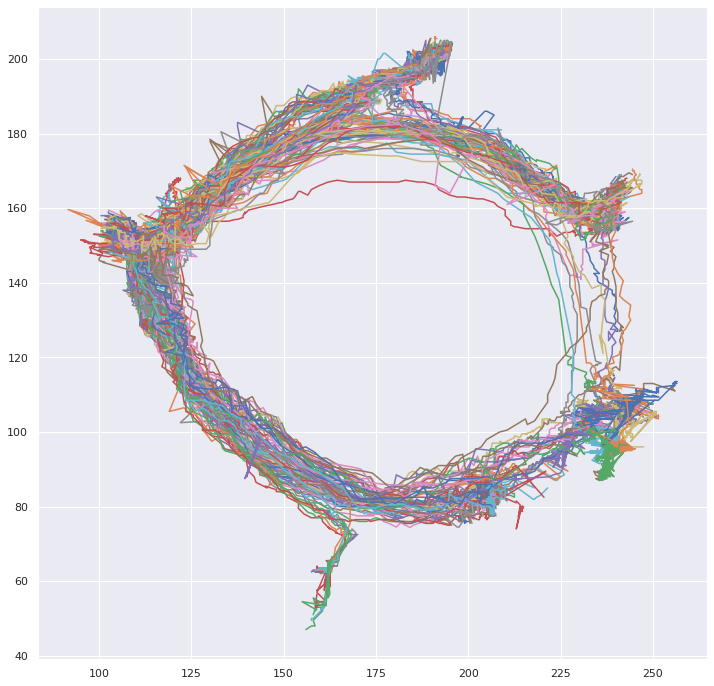

In [49]:
# Plotting

for traj in traj_lst:
    plt.plot(traj[:, 0], traj[:, 1])

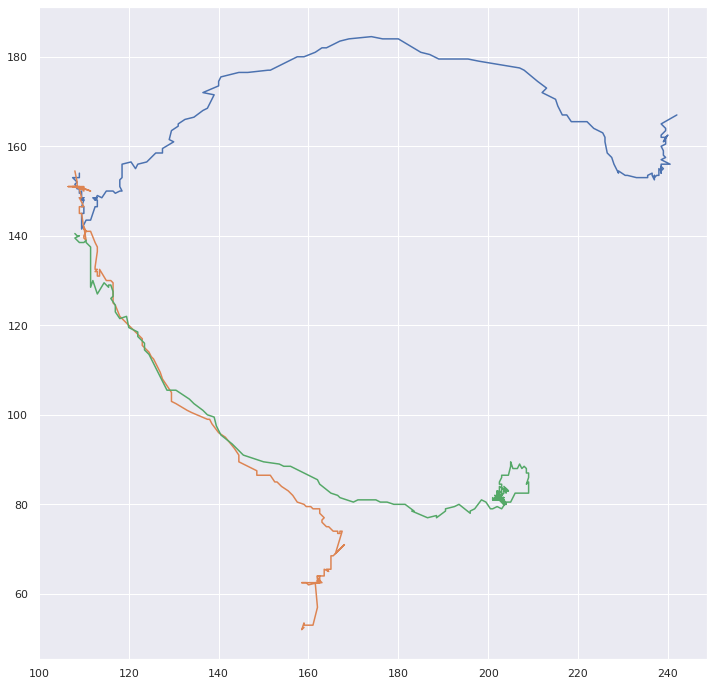

In [52]:
for traj in traj_lst[1:4]:
    plt.plot(traj[:, 0], traj[:, 1])

## Matriz de similitud/distancia/adyacencia

Para calcular la similitud entre dos trayectorias, ocuparemos la distancia de Hausdorff programada en [```scipy.spatial.distance.directed_hausdorff```](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.directed_hausdorff.html). Esto creará la matriz ```A```.

In [65]:
%%time
def hausdorff( u, v):
    d = max(directed_hausdorff(u, v)[0], directed_hausdorff(v, u)[0])
    return d

traj_count = len(traj_lst)
A = np.zeros((traj_count, traj_count))

# This may take a while
for i in range(traj_count):
    for j in range(i + 1, traj_count):
        distance = hausdorff(traj_lst[i], traj_lst[j])
        A[i, j] = distance
        A[j, i] = distance

CPU times: user 24.9 s, sys: 143 ms, total: 25.1 s
Wall time: 25 s


In [66]:
print(A.shape)
A[:10, :4]

(209, 209)


array([[  0.        ,   5.22015325, 119.42466244,  93.03897033],
       [  5.22015325,   0.        , 118.59279067,  90.5       ],
       [119.42466244, 118.59279067,   0.        ,  43.48850423],
       [ 93.03897033,  90.5       ,  43.48850423,   0.        ],
       [110.40040761, 109.41320761,  29.9207286 ,  34.61574786],
       [ 10.79351657,  11.88486432, 118.12070098,  92.38641675],
       [ 29.34706118,  31.08456208, 105.77452434,  96.08459814],
       [ 91.21951546,  90.16789894,  47.5394573 ,  12.08304597],
       [ 91.        ,  90.50966799,  38.46101923,  14.31782106],
       [ 92.00135869,  90.56765427,  44.26341605,  15.53222457]])

## Clustering Espectral

Obtenemos la $D$ que es una matriz diagonal en la que tendremos el ```grado``` de la trayectoría $i$ en la $i-ésima$ entrada.

$D_{i} = \sum_j A_{i, j}$

In [69]:
D_vect = A.sum(axis = 1)
D = np.diag(D_vect)
D[:10, :4]

array([[14077.72913449,     0.        ,     0.        ,     0.        ],
       [    0.        , 14076.94421585,     0.        ,     0.        ],
       [    0.        ,     0.        , 18175.12716976,     0.        ],
       [    0.        ,     0.        ,     0.        , 15590.64414716],
       [    0.        ,     0.        ,     0.        ,     0.        ],
       [    0.        ,     0.        ,     0.        ,     0.        ],
       [    0.        ,     0.        ,     0.        ,     0.        ],
       [    0.        ,     0.        ,     0.        ,     0.        ],
       [    0.        ,     0.        ,     0.        ,     0.        ],
       [    0.        ,     0.        ,     0.        ,     0.        ]])

Calculamos la matriz $L$. No es la matriz Laplaciana de $A$, pero esta relacionada.

$L = D^{-1/2}~A~D^{-1/2}$

In [77]:
D_sqrtinv = np.diag(np.sqrt(1/D_vect))
L_norm = D_sqrtinv @ A @ D_sqrtinv
L_norm[:10, :3]

array([[0.        , 0.00037082, 0.00746602],
       [0.00037082, 0.        , 0.00741422],
       [0.00746602, 0.00741422, 0.        ],
       [0.0062801 , 0.00610889, 0.00258347],
       [0.0072782 , 0.00721332, 0.00173601],
       [0.0007705 , 0.00084843, 0.00742101],
       [0.00215694, 0.00228471, 0.006842  ],
       [0.00618517, 0.00611403, 0.00283691],
       [0.00620721, 0.00617394, 0.00230889],
       [0.00625579, 0.00615848, 0.00264887]])

Hacemos la descomposición en valores singulares 

$L = U~\Sigma~V^T$.

Los eigenvectores van son las columnas de $U$.

In [81]:
U, sigma, _ = linalg.svd(L, full_matrices=False)
print(U.shape, sigma.shape)
sigma[:10]

(209, 209) (209,)


array([26366.0274666 , 26033.5574157 , 25829.41754416, 24770.61025278,
       23191.67458756, 22940.01341376, 21649.91303379, 19854.8221112 ,
       19496.1151679 , 19456.02835255])

Definimos $k$ como el número de clusters que queremos crear y nos *quedamos* con los $k$ eigenvectores correspondientes a los $k$ eigenvalores más grandes.

In [119]:
k = 10
Uk = U[:, :k]
Uk.shape

(209, 10)

Finalmente, normalizamos cada fila de la matriz resultante, $U_k$, y ocupamos éstas como *feature vectors* para KMeans.

In [120]:
y_pred = KMeans(n_clusters = k).fit_predict(normalize(Uk))
y_pred

array([3, 3, 8, 2, 8, 3, 1, 2, 2, 2, 8, 8, 2, 2, 2, 2, 3, 2, 3, 8, 8, 1,
       1, 3, 2, 8, 2, 8, 2, 8, 2, 2, 3, 3, 1, 3, 1, 1, 2, 3, 3, 1, 2, 8,
       1, 2, 8, 8, 1, 3, 1, 1, 1, 1, 8, 1, 1, 3, 1, 1, 1, 3, 1, 3, 2, 9,
       6, 2, 8, 7, 5, 5, 3, 8, 1, 1, 5, 3, 3, 1, 3, 1, 1, 1, 3, 8, 6, 1,
       3, 5, 1, 2, 1, 5, 5, 1, 2, 8, 1, 1, 5, 3, 3, 1, 1, 3, 3, 2, 3, 8,
       2, 1, 8, 2, 2, 1, 1, 1, 3, 3, 1, 3, 8, 1, 3, 3, 2, 3, 2, 3, 3, 8,
       3, 3, 8, 2, 1, 1, 1, 8, 1, 3, 1, 1, 1, 1, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 1, 1, 1, 3, 3, 8, 2, 2, 7, 3, 2, 3, 1, 1, 1, 1, 2, 6, 6,
       6, 5, 1, 1, 6, 4, 5, 1, 9, 9, 2, 4, 4, 0, 6, 9, 6, 9, 9, 3, 1, 3,
       3, 2, 2, 1, 5, 3, 1, 4, 3, 5, 3], dtype=int32)

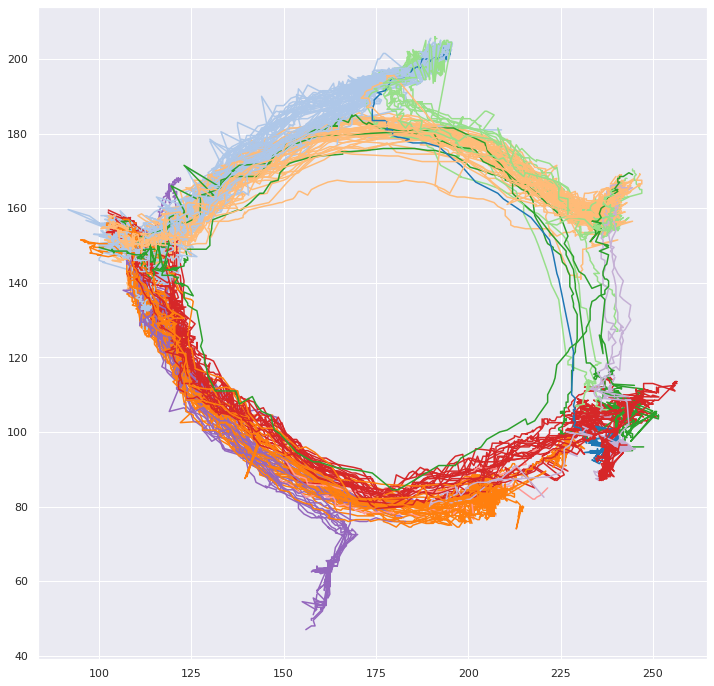

In [121]:
plot_cluster(traj_lst, y_pred)

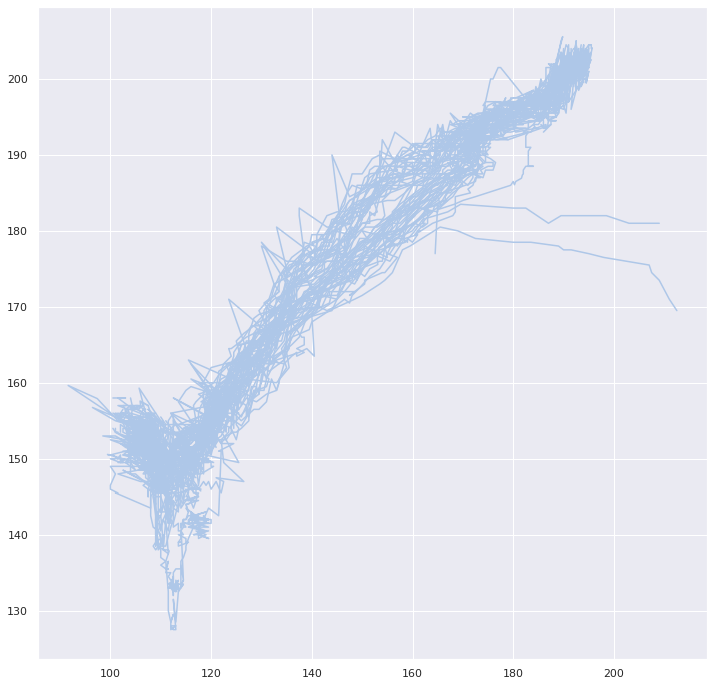

In [134]:
cluster_n = 1
plot_cluster([i for (i, v) in zip(traj_lst, y_pred == cluster_n) if v], y_pred[y_pred == cluster_n])

### Ejercicios

- En este notebook esta implementado el algoritmo de Ng, Jordan y Weiss (NJW). Implementar cualquier otro algoritmo ([referencia](https://sites.stat.washington.edu/spectral/papers/UW-CSE-03-05-01.pdf))
- Comparar los resultados obtenidos con los verdaderos clusters que se encuentran en ```scipy.io.loadmat(filename)['truth']```
- Intentar ejecutar el algoritmo con otros datasets